In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt


In [3]:
# Loading the data
file_path = 'D:/Fuzzy input data.xlsx'  
powdata = pd.read_excel(file_path)

# Preparing the DateTime Column
base_date = pd.to_datetime("2015-01-01")
powdata['Timestamp'] = base_date + pd.to_timedelta(powdata['Time'], unit='D')
powdata['Timestamp'] = powdata['Timestamp'].dt.strftime('%d:%m:%Y %H:%M')

In [5]:
# Creating cyclical time features
parsed_time = pd.to_datetime(powdata['Timestamp'], format='%d:%m:%Y %H:%M')
powdata['HourOfDay'] = parsed_time.dt.hour + parsed_time.dt.minute / 60
powdata['hour_fraction'] = powdata['HourOfDay'] / 24.0
powdata['sin_time'] = np.sin(2 * np.pi * powdata['hour_fraction'])
powdata['cos_time'] = np.cos(2 * np.pi * powdata['hour_fraction'])

# Adding lagged features
powdata['WS_lag1'] = powdata['WS'].shift(1)
powdata['pitch_lag1'] = powdata['pitch'].shift(1)
powdata['Power_lag1'] = powdata['Power'].shift(1)

# Dropping rows with NaNs from lag features
powdata = powdata.dropna().reset_index(drop=True)

In [7]:
# Feature and target selection
features = ['WS', 'pitch', 'WS_lag1', 'pitch_lag1', 'Power_lag1', 'sin_time', 'cos_time']
target = 'Power'
X = powdata[features].values
y = powdata[target].values

# Train and test data splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Defining MOE model
class TimeMOE(tf.keras.Model):
    def __init__(self, num_experts=3, hidden_units=64):
        super(TimeMOE, self).__init__()
        self.experts = [tf.keras.layers.Dense(hidden_units, activation='relu') for _ in range(num_experts)]
        self.gate = tf.keras.layers.Dense(num_experts, activation='softmax')
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        expert_outputs = [expert(inputs) for expert in self.experts]
        expert_outputs = tf.stack(expert_outputs, axis=1)
        gate_weights = self.gate(inputs)
        output = tf.reduce_sum(expert_outputs * tf.expand_dims(gate_weights, axis=-1), axis=1)
        return self.output_layer(output)


model = TimeMOE(num_experts=3, hidden_units=64)
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='mse')

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1
)

Epoch 1/200
420/420 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 109608.8828 - val_loss: 109523.6016
Epoch 2/200
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 51879.7891 - val_loss: 28362.2305
Epoch 3/200
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 20437.1797 - val_loss: 14814.6846
Epoch 4/200
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 13946.8828 - val_loss: 12861.3535
Epoch 5/200
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 10719.9033 - val_loss: 10139.4062
Epoch 6/200
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7843.6045 - val_loss: 7454.0137
Epoch 7/200
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5619.2588 - val_loss: 5458.5269
Epoch 8/200
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4053.1814 - val_loss: 4009.7566
Epoch 9/200
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2856.3176 - val_loss: 2773.8354
Epoch 10/200
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1890.5791 - val_loss: 1821.3942
Epoch 11/200
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - l

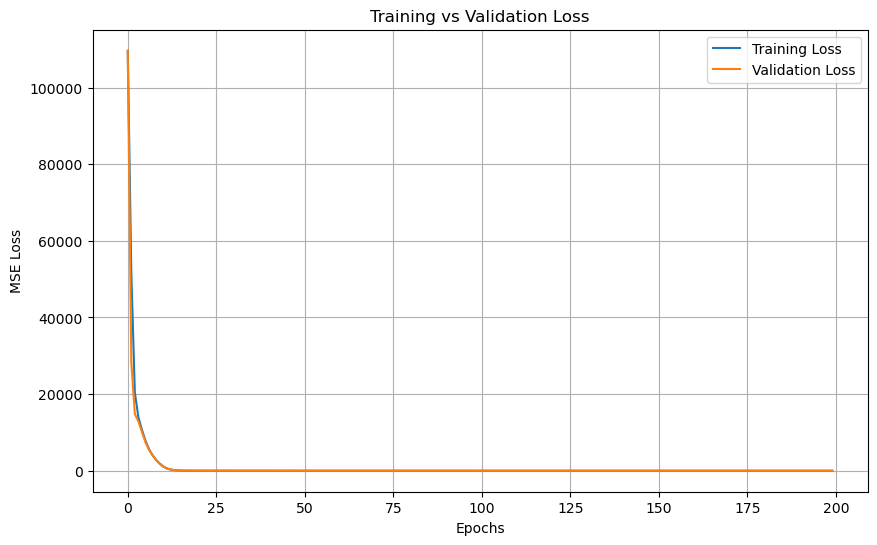

In [10]:
# Plotting training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [11]:
# Error Metrics
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE: 1.490
MSE: 2.219
MAE: 1.132


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


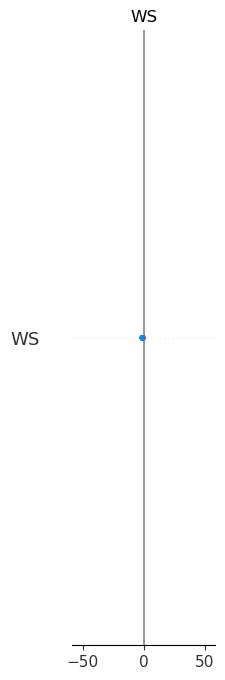

In [12]:
# SHAP Interpretability
explainer = shap.KernelExplainer(model.predict, X_train[:100])  
shap_values = explainer.shap_values(X_test[:10])

shap.summary_plot(shap_values, X_test[:10], feature_names=features)


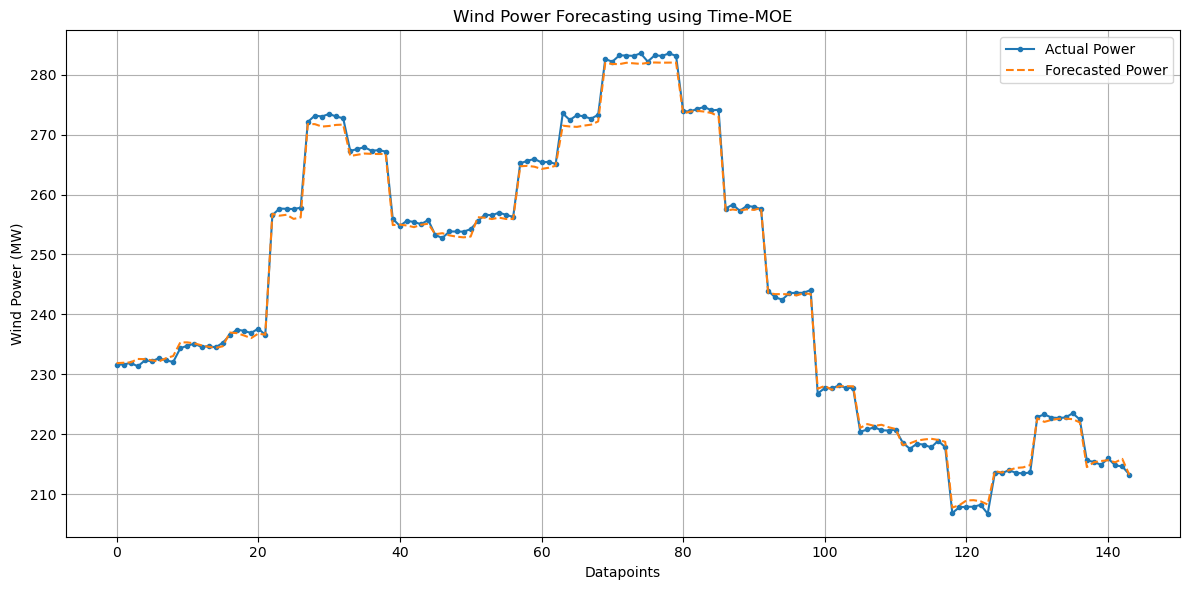

In [27]:
# Plotting actual vs forecasted wind power values 
plt.figure(figsize=(12, 6))
datapoints = range(144)  

plt.plot(datapoints, y_test[-144:], label='Actual Power', marker='.')
plt.plot(datapoints, y_pred[-144:], label='Forecasted Power', linestyle='--')

plt.xlabel("Datapoints")
plt.ylabel("Wind Power (MW)")
plt.title("Wind Power Forecasting using Time-MOE")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
